In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")

### Define LLM

In [2]:
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = GROQ_API_KEY

llm = ChatGroq(
        model="gemma2-9b-it",
        temperature=0.6)

In [3]:
# from langchain_ollama import ChatOllama

# llm = ChatOllama(
#     model="dolphin3:8b",
#     temperature=0.6
# )

### Define Tools

#### Wikipedia Tool

In [4]:
import requests

WIKI_API_URL = "https://en.wikipedia.org/w/api.php"

def search_wikipedia(query: str):
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "exintro": True,
        "explaintext": True,
        "titles": query
    }
    response = requests.get(WIKI_API_URL, params=params)
    data = response.json()
    page = next(iter(data["query"]["pages"].values()))
    return page.get("extract", "")

#### Tavily Web Scraper

In [5]:
from langchain_tavily import TavilySearch

def search_google(query: str):
    tavily_tool = TavilySearch(
        max_results=5,
        topic="general"
        )
    try:
        response = tavily_tool.invoke({"query": query})
        return response
    except requests.exceptions.RequestException as e:
        print("Request failed:", e)
        return []
    except ValueError as e:
        print("Response was not JSON:", e)
        return []
    

### Define Agents

#### Web and Wikipedia Researcher Agent (Researcher Agent)

In [6]:
def run_researcher(query: str):
    google_results = search_google(query)
    wikipedia_results = search_wikipedia(query)
    return {
        "google": google_results,
        "wiki": wikipedia_results
    }

In [7]:
research_results = run_researcher("Machine Learning")
research_results

{'google': {'query': 'Machine Learning',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'title': 'Machine Learning Tutorial - GeeksforGeeks',
    'url': 'https://www.geeksforgeeks.org/machine-learning/machine-learning/',
    'content': 'Machine learning is a branch of Artificial Intelligence that focuses on developing models and algorithms that let computers learn from data without being explicitly programmed for every task. In simple words, ML teaches the systems to think and understand like humans by learning from the data.It can.',
    'score': 0.88705814,
    'raw_content': None},
   {'title': 'What is machine learning? - IBM',
    'url': 'https://www.ibm.com/think/topics/machine-learning',
    'content': 'Machine learning (ML) is a branch of artificial intelligence (AI) focused on enabling computers and machines to imitate the way that humans learn, to perform tasks autonomously, and to improve their performance and accuracy through experience and 

#### Summarizer Agent
- Summarize data from Researcher Agent

In [8]:
def run_summarizer(raw_data: dict):
    def stringify(value):
        if isinstance(value, list):
            return "\n".join([str(v) for v in value])
        return str(value)
    
    combined_text = "\n".join([stringify(v) for v in raw_data.values()])
    prompt = f"""
You are an expert career roadmap planner.

When the user asks about career paths, courses, or preparation strategies, provide a structured roadmap from beginner to expert.

Recommend specific courses and learning resources from platforms like Coursera, edX, DeepLearning.AI, and others.

First,strictly maintain the maximum number of nodes as 20.

Break down the career roadmap into clear **phases** using the following format:

Phase -> Subtopics -> Recommended Tools or Concepts -> Estimated time to complete

🔁 Use arrows (->) **only**. Do **not** use colons, asterisks (*), dots (.), slashes (/) or lists. Wrap multi-word terms with underscores (e.g., Machine_Learning, Data_Structures).

Example:
AI_Engineer -> Programming_Fundamentals -> Python_SQL_Libraries -> 4_weeks  
AI_Engineer -> ML_Foundations -> Scikit_Learn_Pandas_Numpy -> 3_weeks

✳️ Ensure:
- 12 to 20 roadmap paths
- Realistic timelines and achievable steps
- Encourage user commitment and consistency
- Every path must start from a clear role (e.g., AI_Engineer, Data_Scientist)

Use the following context to build the roadmap:
{combined_text}
"""


    response = llm.invoke(prompt)
    try:
        return response["choices"][0]["message"]["content"]
    except Exception:
        return str(response)



In [9]:
summarizer_results = run_summarizer(research_results)
print(summarizer_results)

content='AI_Engineer -> Programming_Fundamentals -> Python_SQL_Libraries -> 4_weeks\nAI_Engineer -> ML_Foundations -> Scikit_Learn_Pandas_Numpy -> 3_weeks\nAI_Engineer -> Deep_Learning -> TensorFlow_Keras -> 6_weeks\nAI_Engineer -> Computer_Vision -> OpenCV_TensorFlow -> 5_weeks\nAI_Engineer -> Natural_Language_Processing -> NLTK_spaCy -> 4_weeks\nData_Scientist -> Programming_Fundamentals -> Python_SQL_Libraries -> 4_weeks\nData_Scientist -> Data_Analysis -> Pandas_NumPy_Matplotlib -> 3_weeks\nData_Scientist -> Statistical_Modeling -> Hypothesis_Testing_Regression -> 3_weeks\nData_Scientist -> Machine_Learning -> Scikit_Learn_Logistic_Regression -> 4_weeks\nData_Scientist -> Deep_Learning -> TensorFlow_Keras -> 6_weeks\nData_Analyst -> Data_Manipulation -> SQL_Python -> 3_weeks\nData_Analyst -> Data_Visualization -> Tableau_PowerBI -> 3_weeks\nData_Analyst -> Data_Reporting -> Excel_BI_Tools -> 2_weeks\nData_Engineer -> Database_Management -> SQL_NoSQL -> 4_weeks\nData_Engineer -> Dat

#### Mapper Agent

In [10]:
def run_mapper(summarized_data: str):
    lines = summarized_data.split("\\n")
    nodes = []
    edges = []
    added_nodes = set()
    for line in lines:
        parts = [part.strip() for part in line.split("->")]
        for part in parts:
            if part and part not in added_nodes:
                nodes.append({"name": part})
                added_nodes.add(part)
        for i in range(len(parts) - 1):
            edges.append({
                "source": parts[i],
                "target": parts[i+1]
            })
    return {
        "nodes": nodes,
        "edges": edges
    }

In [11]:
mapper_results = run_mapper(summarizer_results)
mapper_results

{'nodes': [{'name': "content='AI_Engineer"},
  {'name': 'Programming_Fundamentals'},
  {'name': 'Python_SQL_Libraries'},
  {'name': '4_weeks'},
  {'name': 'AI_Engineer'},
  {'name': 'ML_Foundations'},
  {'name': 'Scikit_Learn_Pandas_Numpy'},
  {'name': '3_weeks'},
  {'name': 'Deep_Learning'},
  {'name': 'TensorFlow_Keras'},
  {'name': '6_weeks'},
  {'name': 'Computer_Vision'},
  {'name': 'OpenCV_TensorFlow'},
  {'name': '5_weeks'},
  {'name': 'Natural_Language_Processing'},
  {'name': 'NLTK_spaCy'},
  {'name': 'Data_Scientist'},
  {'name': 'Data_Analysis'},
  {'name': 'Pandas_NumPy_Matplotlib'},
  {'name': 'Statistical_Modeling'},
  {'name': 'Hypothesis_Testing_Regression'},
  {'name': 'Machine_Learning'},
  {'name': 'Scikit_Learn_Logistic_Regression'},
  {'name': 'Data_Analyst'},
  {'name': 'Data_Manipulation'},
  {'name': 'SQL_Python'},
  {'name': 'Data_Visualization'},
  {'name': 'Tableau_PowerBI'},
  {'name': 'Data_Reporting'},
  {'name': 'Excel_BI_Tools'},
  {'name': '2_weeks'},
 

### Define Workflow

In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

class AgentState(TypedDict):
    input: str
    raw_info: dict
    summary: str
    result: dict

graph = StateGraph(AgentState)

def researcher_node(state: AgentState):
    return {"raw_info": run_researcher(state["input"])}
    
def summarizer_node(state: AgentState):
    return {"summary": run_summarizer(state["raw_info"])}
    
def mapper_node(state: AgentState):
    return {"result": run_mapper(state["summary"])}
    
graph.add_node("researcher", researcher_node)
graph.add_node("summarizer", summarizer_node)
graph.add_node("mapper", mapper_node)

graph.add_edge(START, "researcher")
graph.add_edge("researcher", "summarizer")
graph.add_edge("summarizer", "mapper")
graph.add_edge("mapper", END)

app = graph.compile()

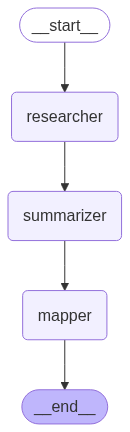

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Define Graphviz Diagram Generator

In [14]:
from graphviz import Digraph
import regex as re

def sanitize(text):
    # Remove unwanted terms
    unwanted_patterns = [r'\bn\b', r'content_', r'response_metadata', r'token_usage', r'additional_kwargs']
    for pattern in unwanted_patterns:
        text = re.sub(pattern, '', text)

    # Replace non-alphanumeric characters (excluding underscores) with underscores
    text = re.sub(r'[^\w]', '_', text)

    # Strip any extra spaces or underscores at the ends
    text = text.strip('_').strip()

    # Truncate the text if too long (120 characters max)
    return f'"{text[:120]}..."' if len(text) > 120 else f'"{text}"'

def export_to_svg(graph_data, file_name="output_graph"):
    dot = Digraph(format="svg")
    dot.attr(bgcolor="white")
    dot.attr("graph", rankdir="TB", ranksep="0.3", nodesep="0.2")
    dot.attr("node", shape="box", style="filled, setlinewidth(3)", width="2", fontsize="24", height="1",
             fillcolor="lightblue", color="blue", fontcolor="black")
    dot.attr("edge", arrowsize="1.4", color="gray", penwidth="2")

    seen = set()
    for node in graph_data["nodes"]:
        name = sanitize(node["name"])
        if name and name not in seen:
            dot.node(name)
            seen.add(name)

    for edge in graph_data["edges"]:
        source = sanitize(edge["source"])
        target = sanitize(edge["target"])
        if source and target:
            dot.edge(source, target)

    image = dot.pipe(format="svg").decode("utf-8")
    return image           





In [15]:
query = "Give me a road map to become AI Engineer"

result = app.invoke({"input": query})
result["result"]

{'nodes': [{'name': "content='AI_Engineer"},
  {'name': 'Programming_Fundamentals'},
  {'name': 'Python_SQL_Libraries'},
  {'name': '4_weeks'},
  {'name': 'AI_Engineer'},
  {'name': 'Data_Structures_Algorithms'},
  {'name': 'Data_Structures_Algorithms_Practice'},
  {'name': '6_weeks'},
  {'name': 'Machine_Learning_Foundations'},
  {'name': 'Scikit_Learn_Pandas_Numpy'},
  {'name': '8_weeks'},
  {'name': 'Deep_Learning'},
  {'name': 'TensorFlow_Keras'},
  {'name': '10_weeks'},
  {'name': 'Computer_Vision'},
  {'name': 'OpenCV_PyTorch'},
  {'name': 'Natural_Language_Processing'},
  {'name': 'SpaCy_Transformers'},
  {'name': 'AI_Ethics_and_Bias'},
  {'name': 'Ethics_in_AI_Resources'},
  {'name': 'Cloud_Computing'},
  {'name': 'AWS_Azure_GCP'},
  {'name': 'Deployment_and_MLOps'},
  {'name': 'Docker_Kubernetes'},
  {'name': 'Project_Portfolio'},
  {'name': 'AI_Projects'},
  {'name': '12_weeks'},
  {'name': 'Communication_and_Collaboration'},
  {'name': 'Technical_Communication'},
  {'name': 

In [16]:
graph = result["result"]
graph_data = export_to_svg(graph)

In [17]:
graph_data

'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 13.0.1 (20250615.1724)\r\n -->\r\n<!-- Pages: 1 -->\r\n<svg width="3659pt" height="362pt"\r\n viewBox="0.00 0.00 3659.00 362.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\r\n<g id="graph0" class="graph" transform="scale(1 1) rotate(0) translate(4 358)">\r\n<polygon fill="white" stroke="none" points="-4,4 -4,-358 3655.12,-358 3655.12,4 -4,4"/>\r\n<!-- &quot;content__AI_Engineer&quot; -->\r\n<g id="node1" class="node">\r\n<title>&quot;content__AI_Engineer&quot;</title>\r\n<polygon fill="lightblue" stroke="blue" stroke-width="3" points="284.5,-354 30,-354 30,-282 284.5,-282 284.5,-354"/>\r\n<text xml:space="preserve" text-anchor="middle" x="157.25" y="-308.7" font-family="Times New Roman,serif" font-size="24.00">&quot;content__AI_Engineer&quot;</text>\r\n<

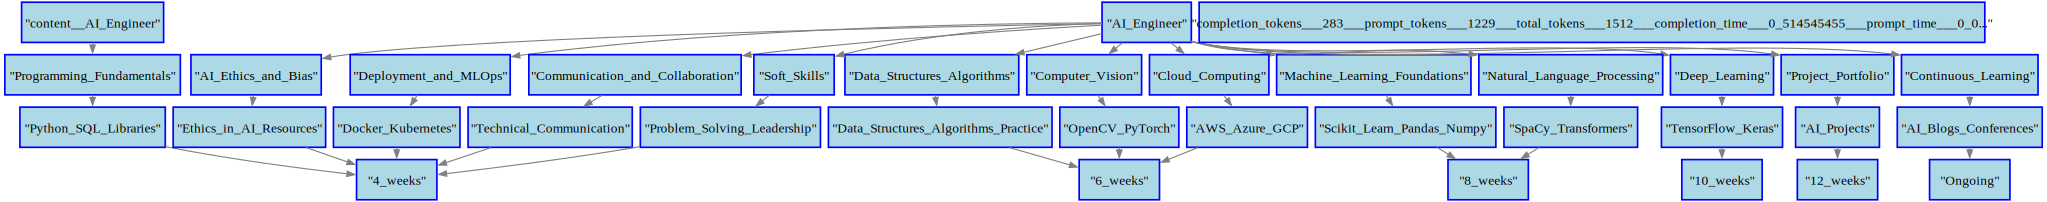

In [18]:
from IPython.display import SVG, display

display(SVG(graph_data))
